In [123]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [124]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with a positive semidefinite covariance matrix
def simulate_data(N):
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')  # Monthly start frequency
    N = len(dates)

    # Define mean and a valid positive semidefinite covariance matrix
    mean = [2.5, 5.0, 0.2, 20, 100, 100, 3]
    cov = np.array([
        [0.25, 0.05, 0, 0.1, 0.1, 0.1, 0.1],
        [0.05, 1, 0, 0.05, 0.1, 0.1, 0.05],
        [0, 0, 0.04, 0, 0, 0, 0],
        [0.1, 0.05, 0, 5, 0.5, 0.5, 0.1],
        [0.1, 0.1, 0, 0.5, 10, 1, 0.2],
        [0.1, 0.1, 0, 0.5, 1, 10, 0.2],
        [0.1, 0.05, 0, 0.1, 0.2, 0.2, 1]
    ])
    # Ensure covariance matrix is symmetric
    cov = (cov + cov.T) / 2

    # Simulate multivariate normal data
    data = np.random.multivariate_normal(mean, cov, N)

    df = pd.DataFrame(data, columns=['Federal Funds Rate', 'Unemployment Rate', 'Yield Curve Inversion',
                                     'VIX', 'BCI', 'CCI', 'GDP Growth'], index=dates)
    df['Yield Curve Inversion'] = (df['Yield Curve Inversion'] > 0.5).astype(int)  # Binarize the inversion indicator

    return df

In [125]:
data = simulate_data(1000)

# Example of running a Vector Autoregression (VAR)
def var_causality(data):
    model = VAR(data)
    results = model.fit(maxlags=12, ic='aic')
    print(results.summary())

# Apply VAR model to the data
var_causality(data[['Federal Funds Rate', 'Unemployment Rate', 'VIX', 'BCI', 'CCI', 'GDP Growth']])

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, May, 2024
Time:                     16:37:15
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    4.60348
Nobs:                     288.000    HQIC:                   4.55775
Log likelihood:          -3097.84    FPE:                    92.4961
AIC:                      4.52717    Det(Omega_mle):         90.5923
--------------------------------------------------------------------
Results for equation Federal Funds Rate
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         2.472341         0.028666           86.246           0.000

Results for equation Unemployment Rate
           coefficient       std. error           t-stat            prob
---------------------------------------

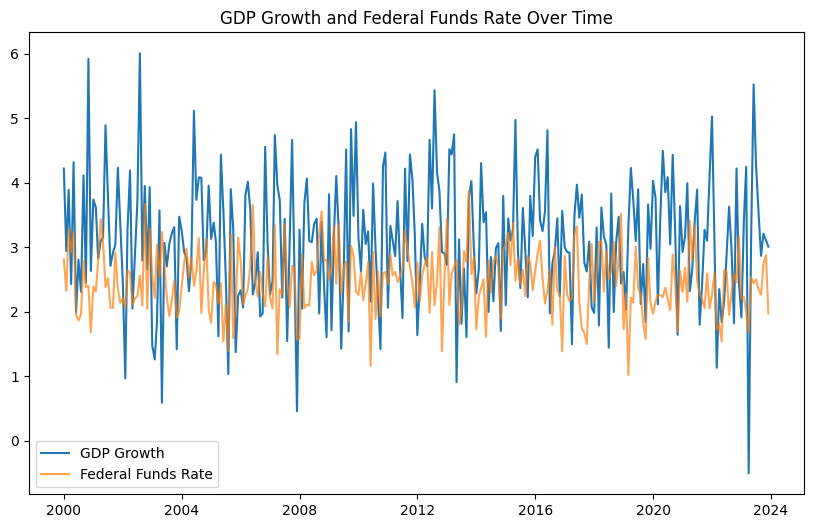

In [126]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['GDP Growth'], label='GDP Growth')
plt.plot(data.index, data['Federal Funds Rate'], label='Federal Funds Rate', alpha=0.7)
plt.legend()
plt.title('GDP Growth and Federal Funds Rate Over Time')
plt.show()

In [127]:
# Now month to month percentage changes
# identify first yield curve inversion dates
# VAR model too

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [128]:
def simulate_data(N):
    start_date = '2000-01-01'
    end_date = '2023-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    N = len(dates)

    mean = [2.5, 5.0, 0.2, 20, 100, 100, 3]
    cov = np.array([
        [0.25, 0.05, 0, 0.1, 0.1, 0.1, 0.1],
        [0.05, 1, 0, 0.05, 0.1, 0.1, 0.05],
        [0, 0, 0.04, 0, 0, 0, 0],
        [0.1, 0.05, 0, 5, 0.5, 0.5, 0.1],
        [0.1, 0.1, 0, 0.5, 10, 1, 0.2],
        [0.1, 0.1, 0, 0.5, 1, 10, 0.2],
        [0.1, 0.05, 0, 0.1, 0.2, 0.2, 1]
    ])
    cov = (cov + cov.T) / 2

    data = np.random.multivariate_normal(mean, cov, N)
    df = pd.DataFrame(data, columns=['Federal Funds Rate', 'Unemployment Rate', 'Yield Curve Inversion',
                                     'VIX', 'BCI', 'CCI', 'GDP Growth'], index=dates)
    df['Yield Curve Inversion'] = (df['Yield Curve Inversion'] > 0.5).astype(int)
    return df


In [129]:
def calculate_monthly_changes(data):
    for col in ['VIX', 'BCI', 'CCI', 'GDP Growth']:
        data[col + ' % Change'] = data[col].pct_change() * 100
    return data

def identify_first_inversions(data):
    data['First YC Inversion'] = (data['Yield Curve Inversion'].diff() == 1).astype(int)
    data['12M First YC Inversion'] = data['First YC Inversion'].rolling(window=12, min_periods=1).max()
    return data


In [130]:
# Function to remove outliers
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data[column] = np.where(data[column] > upper_bound, upper_bound, 
                            np.where(data[column] < lower_bound, lower_bound, data[column]))
    return data

# Function to test stationarity
def test_stationarity(data, column):
    result = adfuller(data[column].dropna())  # Ensure to dropna for testing
    print(f'ADF Statistic for {column}: {result[0]}')
    print('p-value:', result[1])
    if result[1] > 0.05:
        print(f"{column} is not stationary")
    else:
        print(f"{column} is stationary")

In [131]:
def clean_data(data):
    # Replace infinite values with NaNs
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with any NaNs (or you might choose to fill them instead)
    data.dropna(inplace=True)

    return data

# Apply the cleaning function
data = calculate_monthly_changes(data)
data = clean_data(data)  # Clean data to remove or impute NaNs/Infs
data = identify_first_inversions(data)

# Test each series for stationarity
for col in ['GDP Growth % Change', 'VIX % Change', 'BCI % Change', 'CCI % Change']:
    test_stationarity(data, col)

# Remove outliers for each column
for col in ['GDP Growth % Change', 'VIX % Change', 'BCI % Change', 'CCI % Change']:
    data = remove_outliers(data, col)

ADF Statistic for GDP Growth % Change: -21.28945947361822
p-value: 0.0
GDP Growth % Change is stationary
ADF Statistic for VIX % Change: -5.9270699082977805
p-value: 2.4295162667869405e-07
VIX % Change is stationary
ADF Statistic for BCI % Change: -8.55550317938924
p-value: 8.982419036671319e-14
BCI % Change is stationary
ADF Statistic for CCI % Change: -9.432195086057092
p-value: 5.15428893244417e-16
CCI % Change is stationary


In [132]:
# Fit VAR model with fewer lags
def fit_var_model(data, lags=4):  # Reduced lags
    model = VAR(data[['GDP Growth % Change', 'VIX % Change', 'BCI % Change', 'CCI % Change', '12M First YC Inversion']])
    try:
        results = model.fit(maxlags=lags, ic='aic')
        print(results.summary())
    except Exception as e:
        print("Error in fitting model:", e)

# Apply the modified fit function
fit_var_model(data)

def plot_transformed_data(data):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['GDP Growth % Change'], label='GDP Growth % Change')
    plt.plot(data.index, data['VIX % Change'], label='VIX % Change', alpha=0.7)
    plt.legend()
    plt.title('Month/Month % Change in GDP Growth and VIX')
    plt.show()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, May, 2024
Time:                     16:37:15
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    16.1361
Nobs:                     284.000    HQIC:                   15.5204
Log likelihood:          -4080.27    FPE:                3.64495e+06
AIC:                      15.1083    Det(Omega_mle):     2.77126e+06
--------------------------------------------------------------------
Results for equation GDP Growth % Change
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            20.992576         4.250007            4.939           0.000
L1.GDP Growth % Change           -0.596252         0.059980           -9.941           0.00

In [136]:
# Perform Granger Causality tests
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
def test_granger_causality(data, maxlag=4):
    results = {}
    for var in ['VIX % Change', 'BCI % Change', 'CCI % Change']:
        print(f"Testing causality to GDP Growth from {var}:")
        results[var] = grangercausalitytests(data[['GDP Growth % Change', var]], maxlag=maxlag, verbose=True)
    return results


In [138]:
from statsmodels.tsa.stattools import grangercausalitytests

def test_granger_causality(data, variables, maxlag=4):
    results = {}
    for var in variables:
        print(f"Testing causality to GDP Growth from {var}:")
        gc_result = grangercausalitytests(data[['GDP Growth % Change', var]], maxlag=maxlag, verbose=True)
        results[var] = gc_result
    return results

# Example of usage:
# Assuming 'data' has already been cleaned and prepared with monthly % changes
variables = ['VIX % Change', 'BCI % Change', 'CCI % Change']
granger_results = test_granger_causality(data, variables)


Testing causality to GDP Growth from VIX % Change:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7183  , p=0.1910  , df_denom=283, df_num=1
ssr based chi2 test:   chi2=1.7365  , p=0.1876  , df=1
likelihood ratio test: chi2=1.7312  , p=0.1883  , df=1
parameter F test:         F=1.7183  , p=0.1910  , df_denom=283, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4076  , p=0.2465  , df_denom=280, df_num=2
ssr based chi2 test:   chi2=2.8654  , p=0.2387  , df=2
likelihood ratio test: chi2=2.8511  , p=0.2404  , df=2
parameter F test:         F=1.4076  , p=0.2465  , df_denom=280, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8199  , p=0.4838  , df_denom=277, df_num=3
ssr based chi2 test:   chi2=2.5219  , p=0.4714  , df=3
likelihood ratio test: chi2=2.5107  , p=0.4734  , df=3
parameter F test:         F=0.8199  , p=0.4838  , df_denom=277, df_num=3

Granger Causality
number of lags (no zero)

c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


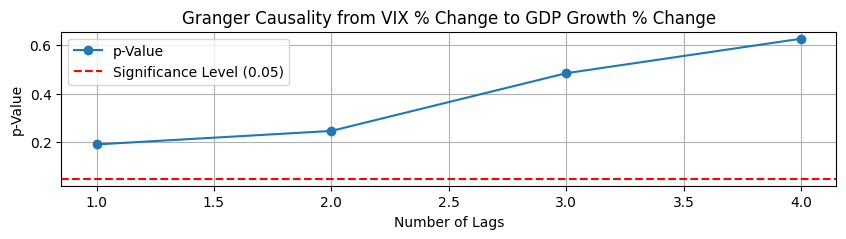

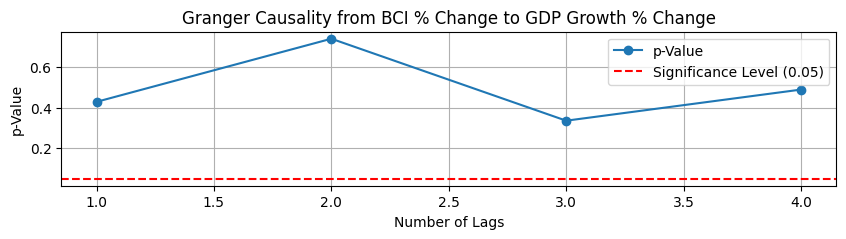

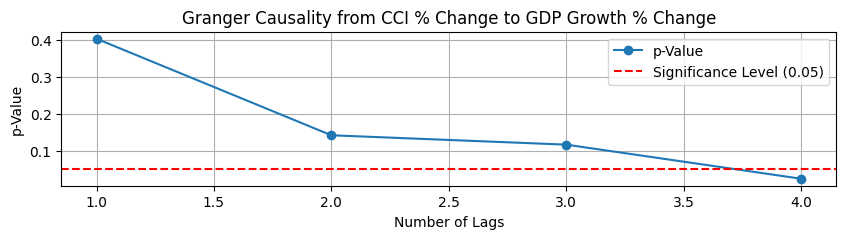

In [139]:
import matplotlib.pyplot as plt

def plot_granger_results(granger_results):
    for variable, result in granger_results.items():
        p_values = [round(result[lag+1][0]['ssr_ftest'][1], 4) for lag in range(len(result))]
        plt.figure(figsize=(10, 2))
        plt.plot(range(1, len(p_values) + 1), p_values, marker='o', linestyle='-', label='p-Value')
        plt.title(f'Granger Causality from {variable} to GDP Growth % Change')
        plt.xlabel('Number of Lags')
        plt.ylabel('p-Value')
        plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_granger_results(granger_results)


In [137]:
# RUN THIS CELL TO RUN THE OTHER FUNCTIONS SEQUENTIALLY
# Main execution
data = simulate_data(288)
data = calculate_monthly_changes(data)
data = clean_data(data)
data = identify_first_inversions(data)
for col in ['GDP Growth % Change', 'VIX % Change', 'BCI % Change', 'CCI % Change']:
    test_stationarity(data, col)
granger_results = test_granger_causality(data)

ADF Statistic for GDP Growth % Change: -12.703251194834758
p-value: 1.0685746162678919e-23
GDP Growth % Change is stationary
ADF Statistic for VIX % Change: -8.639847253000152
p-value: 5.4635106853489015e-14
VIX % Change is stationary
ADF Statistic for BCI % Change: -8.82988788922037
p-value: 1.781607038477862e-14
BCI % Change is stationary
ADF Statistic for CCI % Change: -9.062413329315705
p-value: 4.525702846651187e-15
CCI % Change is stationary
Testing causality to GDP Growth from VIX % Change:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7183  , p=0.1910  , df_denom=283, df_num=1
ssr based chi2 test:   chi2=1.7365  , p=0.1876  , df=1
likelihood ratio test: chi2=1.7312  , p=0.1883  , df=1
parameter F test:         F=1.7183  , p=0.1910  , df_denom=283, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4076  , p=0.2465  , df_denom=280, df_num=2
ssr based chi2 test:   chi2=2.8654  , p=0.2387  , df=2
likelihood ratio test

c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\ellac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
# Output analysis

'''

VAR shows GDP growth is influenced by its own historical values, but less by the changes in VIX, BCI, and CCI within the short lags
Considering broader historical data might change this thoughm especially given the Granger results

Higher lag analyses of the Granger causality tests suggest that economic indicators like VIX have a delayed effect on GDP growth

Data Stationairty confirms that data transformations were effective in stabilizing the series making them suitable for the applied time series analyses


'''